#### AWS updates pricing and offers continually

###### To future proof this, there are three key steps to get current AWS data:
###### 1 - get  list of all AWS services
###### 2 - get todays offers for EC2
###### 3 - get today's pricing for all EC2 InstanceTypes

#### before you get started, it may be helpful to install the juptyer notebook extensions
#### which must be done from the terminal, since pip install does not work from within jupyter notebooks
#### here is the link:  https://github.com/ipython-contrib/jupyter_contrib_nbextensions


In [1]:
# import core python libraries for retrieving and analysis of AWS data
import pandas as pd
import numpy as np
import boto3
import json
from sklearn.cluster import KMeans

# import visualization libraries, and do some configuration for jupyter notebook
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# 1 - get the complete list of all AWS services for all regions
# https://aws.amazon.com/blogs/aws/new-aws-price-list-api/

# import current master AWS index for all services
import requests
offers = requests.get('https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/index.json')
print("master AWS index downloaded", "\n")

master AWS index downloaded 



In [3]:
# 2- Use that AWS index to get the current offers list for EC2 as of today
# hard coded EC2 prices:  offers = requests.get('https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/AmazonEC2/current/index.json')

# get the current URL `suffix` for EC2 pricing from the AWS master index
ec2_offer_path = offers.json()['offers']['AmazonEC2']['currentVersionUrl']
print("EC2 offer path deciphered", "\n")

# construct the complete URL for current EC2 pricing, and retrieve the json file
ec2pricingURL = 'https://pricing.us-east-1.amazonaws.com%s' % ec2_offer_path
print(ec2pricingURL, "\n")

ec2offers = requests.get('https://pricing.us-east-1.amazonaws.com%s' % ec2_offer_path).json()
print("current EC2 offers downloaded", "\n")

EC2 offer path deciphered 

https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/AmazonEC2/current/index.json 

current EC2 offers downloaded 



In [4]:
# 3 - Dynamically, get the actual price list we want
# Pricing information can be accessed by URLs, each structured as follows:
# https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/{offer_code}/current/index.{format}
import requests

#we want the csv, so we have to trim the `index.json` filename off the pricing url
url_base=ec2pricingURL[:-10]

print(url_base)

pricing_csv_url = url_base + 'index.csv'

print(pricing_csv_url)

# write content to csv.  This will fail if you have a prior version of the file open in an editor or spreadsheet
r = requests.get(pricing_csv_url, stream=True)
with open('../data/ec2-prices.csv', 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024): 
        if chunk: # filter out keep-alive new chunks
            f.write(chunk)

print("ec2_prices.csv saved to disk.","\n")

https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/AmazonEC2/current/
https://pricing.us-east-1.amazonaws.com/offers/v1.0/aws/AmazonEC2/current/index.csv
ec2_prices.csv saved to disk. 



In [5]:
# construct set of unique EC2 Instance Types, and do a little cleanup
# count = 0
# uniq = set()
# for sku, data in ec2offers['products'].items():
#    try:
#        count += 1
#        # print(count, sku, data['productFamily'])
#        if data['productFamily'] == 'Compute Instance':
#            # Add EC2 Instance to the set
#            uniq.add(data['attributes']['instanceType'])
#          
#        elif data['productFamily'] == 'Compute':
#            # Add AWS misspelled instanceType for EC2 Instance to the set
#            uniq.add(data['attributes']['instanceType'])
#        
#        else:
#            # skip anything that's not an EC2 Instance  
#            continue
#    except KeyError:
#        # some AWS JSON entries don't have all their keys
#        pass
#        
#for instancetype in sorted(uniq):
#    print(instancetype)

In [6]:
# read the saved data into pandas
# Be sure to skip the first 5 rows of information above row 5 which has the column headers; and get rid of NaN which causes mixed type errors

pricing_df = pd.read_csv("../data/ec2-prices.csv", skiprows = 5, low_memory=False)
pricing_df.set_index(['SKU', 'Location','Instance Type'])

print("number of rows in this dataframe: ", len(pricing_df), "\n")
pricing_df.head()

number of rows in this dataframe:  313789 



,SKU,OfferTermCode,RateCode,TermType,PriceDescription,EffectiveDate,StartingRange,EndingRange,Unit,PricePerUnit,...,Instance Capacity - medium,Instance Capacity - xlarge,Intel AVX Available,Intel AVX2 Available,Intel Turbo Available,Normalization Size Factor,Physical Cores,Pre Installed S/W,Processor Features,serviceName
0,YQHNG5NBWUE3D67S,4NA7Y494T4,YQHNG5NBWUE3D67S.4NA7Y494T4.6YS6EN2CT7,Reserved,"Red Hat Enterprise Linux (Amazon VPC), m4.xlar...",2017-12-31,0.0,inf,Hrs,0.1963,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,Intel AVX; Intel AVX2; Intel Turbo,Amazon Elastic Compute Cloud
1,74DZW9N4CZYAFK93,HU7G6KETJZ,74DZW9N4CZYAFK93.HU7G6KETJZ.6YS6EN2CT7,Reserved,"Windows with SQL Server Standard (Amazon VPC),...",2015-04-30,0.0,inf,Hrs,1.0070,...,NaN,NaN,NaN,NaN,NaN,16.0,NaN,SQL Std,Intel AVX; Intel Turbo,Amazon Elastic Compute Cloud
2,74T3JX59FQU4RXSS,CUZHX8X6JH,74T3JX59FQU4RXSS.CUZHX8X6JH.2TG2D8R56U,Reserved,Upfront Fee,2017-10-31,NaN,NaN,Quantity,33464.0000,...,NaN,NaN,NaN,NaN,NaN,192.0,NaN,NaN,"Intel AVX, Intel AVX2, Intel AVX512, Intel Turbo",Amazon Elastic Compute Cloud
3,AF4M9XS62QDH5P8S,BPH4J8HBKS,AF4M9XS62QDH5P8S.BPH4J8HBKS.6YS6EN2CT7,Reserved,"Linux/UNIX (Amazon VPC), i3.xlarge reserved in...",2017-04-30,0.0,inf,Hrs,0.1950,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,"Intel AVX, Intel AVX2, Intel Turbo",Amazon Elastic Compute Cloud
4,MM89A8ZSTKMB3A6H,HU7G6KETJZ,MM89A8ZSTKMB3A6H.HU7G6KETJZ.2TG2D8R56U,Reserved,Upfront Fee,2016-11-30,NaN,NaN,Quantity,530.0000,...,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,Intel AVX; Intel AVX2; Intel Turbo,Amazon Elastic Compute Cloud


## csv dataframe cleanup --

In [7]:
# Let's get rid of Null instance types, things that are not 'hourly' pricing, and things outside our region of interest
# AWS will reject request if this asks for too much, so to get other regions we would need to iterate over values
pricing_df = pricing_df[(pricing_df["Instance Type"].notnull()) & (pricing_df["Unit"] == "Hrs") & (pricing_df["Location"] == "US East (N. Virginia)")& (pricing_df["ECU"] != "Variable")]
print("number of rows after nan cleanup: ", len(pricing_df), "\n")

number of rows after nan cleanup:  15706 



In [8]:
# memory currently stored as a string
# create new derivative column, to story memory amounts without units, also take out commmas
pricing_df["Memory_GiB"] = pricing_df["Memory"]
pricing_df["Memory_GiB"].replace(regex=True,inplace=True,to_replace=r' GiB',value=r'')
pricing_df["Memory_GiB"].replace(regex=True,inplace=True,to_replace=r',',value=r'')
pricing_df["Memory_GiB"].replace(regex=True,inplace=True,to_replace=r' ',value=r'')

# now cast this new column to float so we can use it as a number going forward
pricing_df['Memory_GiB'] = pricing_df['Memory_GiB'].astype(float)

# ECU currently stored as a string since some values in csv originally contained the value 'variable'
# now cast this new column to float so we can use it as a number going forward
pricing_df['ECU'] = pricing_df['ECU'].astype(float)

# clock speed currently stored as a string
# create new derivative column, to story clock speeds without units, also take out commmas
pricing_df["Clock Speed GHz"] = pricing_df["Clock Speed"]
pricing_df["Clock Speed GHz"].replace(regex=True,inplace=True,to_replace=r'Ghz',value=r'')
pricing_df["Clock Speed GHz"].replace(regex=True,inplace=True,to_replace=r' GHz',value=r'')
pricing_df["Clock Speed GHz"].replace(regex=True,inplace=True,to_replace=r'Up to ',value=r'')
pricing_df["Clock Speed GHz"].replace(regex=True,inplace=True,to_replace=r' ',value=r'')

# now cast this new column to float so we can use it as a number going forward
pricing_df['Clock Speed GHz'] = pricing_df['Clock Speed GHz'].astype(float)


# let's capture the different ways of looking at pricing vs. compute capacity, and compare them.
pricing_df["Price_vCPU"] = pricing_df["PricePerUnit"]/pricing_df["vCPU"]
pricing_df["Price_ECU"] = pricing_df["PricePerUnit"]/pricing_df["ECU"]
pricing_df["Price_vCPU_ECU_ratio"] = round(pricing_df["Price_vCPU"]/pricing_df["Price_ECU"],1)

In [9]:
# put all the names of Instance types into a dictionary, so we can pass that to boto3 and retrieve spot pricing
names = pricing_df["Instance Type"].to_dict()

In [10]:
# show a short sample of Instance Types, to check what we're working with
list(names.values())[0:5]

['r3.8xlarge', 'x1e.xlarge', 'i3.8xlarge', 'g2.2xlarge', 'm4.10xlarge']

In [11]:
# and see how many values in the list
len(list(names.values()))

15706

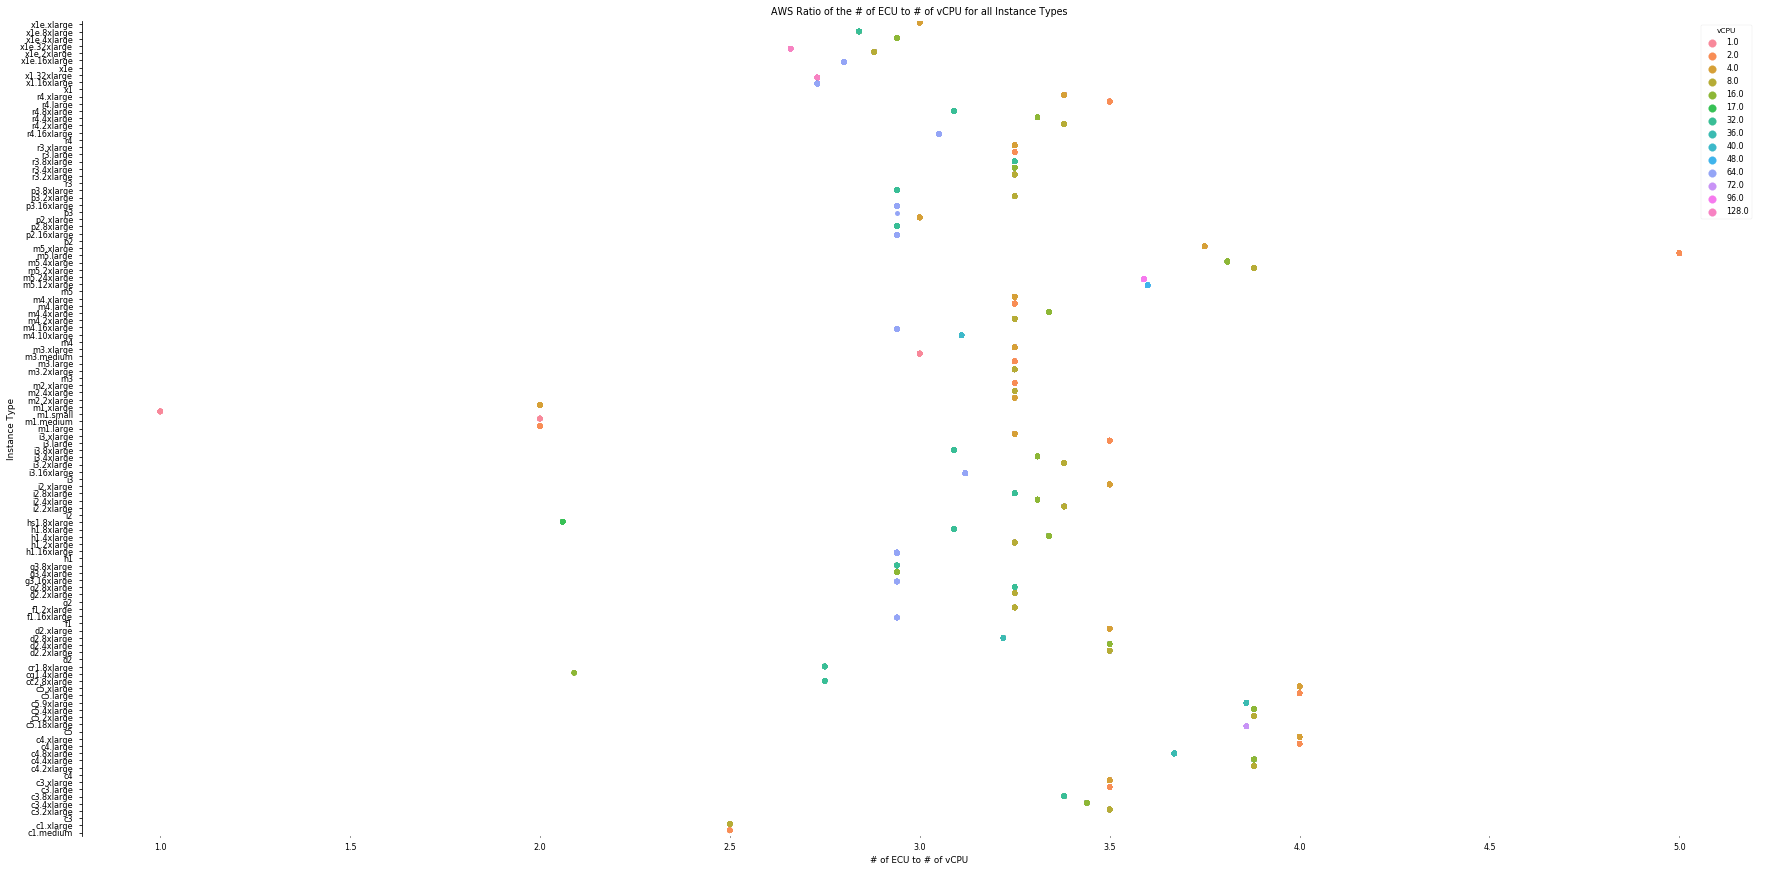

In [12]:
# look at ratio of ECU to vCPU
pricing_df["Num_ECU_vCPU_ratio"] = round(pricing_df["ECU"]/pricing_df["vCPU"],2)

sns.set_context('paper')
plt.figure(figsize=(30, 15))
sns.set_style({'xtick.major.size': 1})

# group our dataframe so axis output is ordered nicely
# adding this option to the sns.swarmplot is very slow: order=sorted(list(names))
pricing_df = pricing_df.sort_values(['Instance Type', 'ECU'], ascending=[False, True])

fig = sns.swarmplot(x="Num_ECU_vCPU_ratio", y="Instance Type", hue="vCPU", data=pricing_df, dodge=True)
sns.despine(left=False, bottom=True)
plt.title("AWS Ratio of the # of ECU to # of vCPU for all Instance Types")
plt.xlabel("# of ECU to # of vCPU")
plt.ylabel("Instance Type")

plt.show(fig)

### pull current spot price history

In [13]:
# setup boto3 request to get spot price data, using complete list of current instance types from the csv
# change the region_name if you need to look in other geos
client = boto3.client('ec2', region_name='us-east-1')
response =client.describe_spot_price_history(InstanceTypes = list(names.values()),
        ProductDescriptions = ['Linux/UNIX'])

In [14]:
# invoke boto3 to collect the spot price history, and put it into a pandas dataframe
spot_price_history = response['SpotPriceHistory']
spot_history_df = pd.DataFrame(spot_price_history)
spot_history_df.SpotPrice = spot_history_df.SpotPrice.astype(float)

In [15]:
print("The spot price history dataframe has : ",len(spot_history_df), " records", "\n")
spot_history_df.head()

The spot price history dataframe has :  1000  records 



,AvailabilityZone,InstanceType,ProductDescription,SpotPrice,Timestamp
0,us-east-1e,f1.2xlarge,Linux/UNIX,0.5118,2018-04-17 05:08:55+00:00
1,us-east-1d,m4.4xlarge,Linux/UNIX,0.2727,2018-04-17 05:08:19+00:00
2,us-east-1e,i3.4xlarge,Linux/UNIX,0.4103,2018-04-17 05:08:06+00:00
3,us-east-1a,m3.2xlarge,Linux/UNIX,0.1147,2018-04-17 05:07:58+00:00
4,us-east-1a,r4.8xlarge,Linux/UNIX,0.6738,2018-04-17 05:00:36+00:00


In [16]:
# as it turns out spot instance history and the csv with orignal pricing data
# have different spellings of "InstanceType" vs "Instance Type" -- not helpful!
# create new derivative column normalizing name of Instance Type so we can do df.merge operations
# we'll match up to spot history, to reduce changes needed in downstream cells

pricing_df["InstanceType"] = (pricing_df["Instance Type"])

In [17]:
# what is in this spot_history_df?
# list(spot_history_df)

In [18]:
# reminder - what are columns in the pricing_df?
# list(pricing_df)

### Notes about important definitions.

AWS enables you to use virtual machines in the cloud, which are virtual containers running on hardware of many different sizes (CPU/RAM).  Although AWS does provide a count of the number of virtual CPU ("vCPU") for each Instance Type, because of the large differences in actual underlying hardware - they created a new artificial benchmark called "ECU" (which means "EC2 Compute Unit".  ECU attempts to compare the actual compute capacity between two machines.  AWS used to publish a definition of an ECU that stated one ECU was "It defines one ECU as the equivalent of a 2007 Intel Xeon or AMD Opteron CPU running at 1 GHz to 1.2 GHz", but that definition has been removed.  Public details on this are scarce, but below are links which provide helpful background.

https://aws.amazon.com/ec2/faqs/#What_is_an_EC2_Compute_Unit_and_why_did_you_introduce_it

https://www.datadoghq.com/blog/are-all-aws-ecu-created-equal/

### some news that AWS may not be actively using ECU anymore
https://blogs.gartner.com/kyle-hilgendorf/2014/04/16/aws-moves-from-ecu-to-vcpu/

https://www.informationweek.com/cloud/amazons-virtual-cpu-you-figure-it-out/a/d-id/1323652?

### so we'll make use of what we have, and recogize that more analysis around published architecture details like clock speeds might be required

### back to our analysis...


In [19]:
# make pivot table, summarizing spot instances by OS and memory size

table = pd.pivot_table(pricing_df,index=["Operating System","TermType","Memory_GiB", "vCPU","Clock Speed","Instance Type"],
                       values=["Price_vCPU","PricePerUnit"],
                       aggfunc={"Price_vCPU":np.mean, "PricePerUnit":np.mean},fill_value=0,margins=False)

print(table)

                                                                      PricePerUnit  \
Operating System TermType Memory_GiB vCPU  Clock Speed Instance Type                 
Linux            OnDemand 3.75       1.0   2.5 GHz     m3.medium          0.168667   
                                     2.0   2.8 GHz     c3.large           0.195333   
                                           2.9 GHz     c4.large           0.191778   
                          4.00       2.0   3.0 Ghz     c5.large           0.180111   
                          7.50       2.0   2.5 GHz     m3.large           0.215222   
                                     4.0   2.8 GHz     c3.xlarge          0.488333   
                                           2.9 GHz     c4.xlarge          0.481167   
                          8.00       2.0   2.4 GHz     m4.large           0.191689   
                                           2.5 GHz     m5.large           0.187667   
                                     4.0   3.0 Ghz    

In [20]:
# a slightly different view, same data - looking from CPU perspective
table = pd.pivot_table(pricing_df,index=["Operating System","TermType", "vCPU","Clock Speed","Memory_GiB","Instance Type"],
                       values=["Price_vCPU"],
                       aggfunc={"Price_vCPU":np.mean},fill_value=0,margins=False)

print(table)

                                                                      Price_vCPU
Operating System TermType vCPU  Clock Speed Memory_GiB Instance Type            
Linux            OnDemand 1.0   2.5 GHz     3.75       m3.medium        0.168667
                          2.0   2.3 GHz     15.25      i3.large         0.115500
                                                       r4.large         0.107378
                                2.4 GHz     8.00       m4.large         0.095844
                                2.5 GHz     7.50       m3.large         0.107611
                                            8.00       m5.large         0.093833
                                            15.25      r3.large         0.119000
                                2.8 GHz     3.75       c3.large         0.097667
                                2.9 GHz     3.75       c4.large         0.095889
                                3.0 Ghz     4.00       c5.large         0.090056
                          4.

In [21]:
# do some calculations to prep data for our graphs
df = spot_history_df.merge(pricing_df, how="inner", on="InstanceType")
df['price_memory_spot'] = df['SpotPrice']/pricing_df['Memory_GiB']
pricing_df['price_memory_spot'] = pricing_df['PricePerUnit']/pricing_df['Memory_GiB']

df['price_ecu_spot'] = df['SpotPrice']/df['ECU']
pricing_df['price_ecu'] = pricing_df['PricePerUnit']/pricing_df['ECU']

df.describe()

c:\python\python36\lib\site-packages\numpy\lib\function_base.py:4406: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,SpotPrice,StartingRange,EndingRange,PricePerUnit,vCPU,ECU,GPU,Instance Capacity - 10xlarge,Instance Capacity - 12xlarge,Instance Capacity - 16xlarge,...,Normalization Size Factor,Physical Cores,Memory_GiB,Clock Speed GHz,Price_vCPU,Price_ECU,Price_vCPU_ECU_ratio,Num_ECU_vCPU_ratio,price_memory_spot,price_ecu_spot
count,173919.000000,173919.0,1.739190e+05,173919.000000,173919.000000,173919.000000,13101.000000,0.0,0.0,0.0,...,173919.000000,0.0,173919.000000,166703.000000,173919.000000,173919.000000,114591.000000,173919.000000,8687.000000,173919.000000
mean,0.696633,0.0,inf,1.571091,20.260282,67.705639,3.444241,NaN,NaN,NaN,...,40.254555,NaN,117.760048,2.541337,0.077933,0.023462,3.400369,3.407261,0.030868,0.009813
std,1.435758,0.0,NaN,3.788397,21.296528,71.348763,4.036858,NaN,NaN,NaN,...,42.428001,NaN,167.132044,0.258661,0.116993,0.036078,0.438828,0.423194,0.141352,0.011573
min,0.004400,0.0,inf,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,...,1.000000,NaN,1.700000,2.300000,0.000000,0.000000,1.000000,1.000000,0.000001,0.002233
25%,0.114600,0.0,inf,0.000000,4.000000,15.000000,1.000000,NaN,NaN,NaN,...,8.000000,NaN,16.000000,2.300000,0.000000,0.000000,3.200000,3.250000,0.001032,0.004446
50%,0.270100,0.0,NaN,0.284000,8.000000,31.000000,1.000000,NaN,NaN,NaN,...,16.000000,NaN,61.000000,2.500000,0.035125,0.010168,3.300000,3.340000,0.004325,0.005488
75%,0.674800,0.0,inf,1.351000,32.000000,99.000000,4.000000,NaN,NaN,NaN,...,64.000000,NaN,128.000000,2.800000,0.095650,0.028615,3.800000,3.750000,0.017994,0.008112
max,14.400000,0.0,inf,45.024000,96.000000,345.000000,16.000000,NaN,NaN,NaN,...,192.000000,NaN,976.000000,3.000000,0.841000,0.692000,5.000000,5.000000,6.003294,0.076596


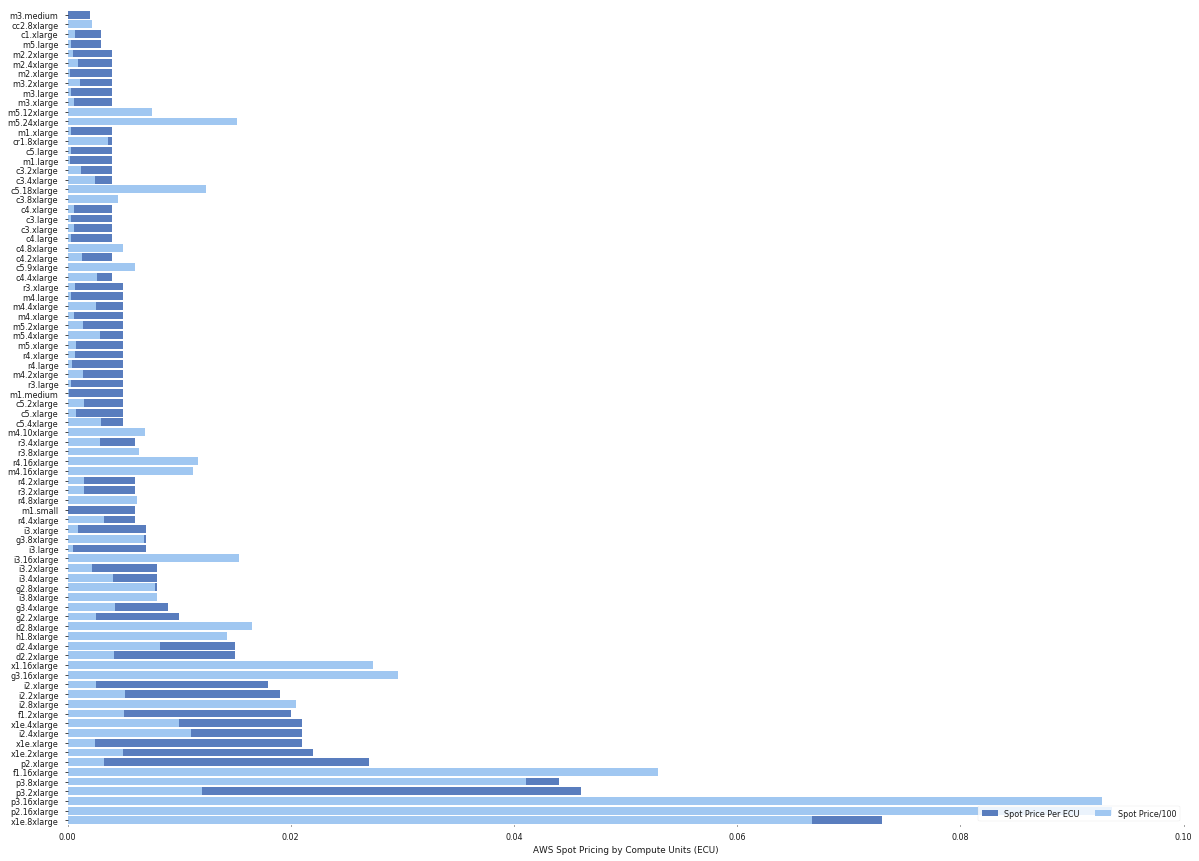

In [22]:
# first chart - spot price per ECU
df_median = df.groupby("InstanceType").median()
df_median["InstanceType"] = df_median.index
df_median["price_ecu_spot"] = df_median.price_ecu_spot.round(3)
df_median["divide_SpotPrice"] = df_median.SpotPrice/100
df_median.sort_values("price_ecu_spot", inplace=True)
plt.subplots(figsize=(20,15))
ax = plt.axes()
sns.set_color_codes("muted")
sns.barplot(x="price_ecu_spot", y="InstanceType", data=df_median,
            label="Spot Price Per ECU", color="b")
sns.set_color_codes("pastel")
sns.barplot(x="divide_SpotPrice", y="InstanceType", data=df_median,
            label="Spot Price/100", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, .1), ylabel="",
       xlabel="AWS Spot Pricing by Compute Units (ECU)")
sns.despine(left=True, bottom=True)

In [23]:
# perform unsupervised machine learning to create clusters of this complex data so we can visualize the entire set; then print out a table
# see new 'cluster' data in last column

numerical_df = df_median.loc[:,["price_ecu_spot", "price_memory_spot"]]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(numerical_df)
scaler.transform(numerical_df)
k_means = KMeans(n_clusters=3)
kmeans = k_means.fit(scaler.transform(numerical_df))
df_median["cluster"]=kmeans.labels_
df_median

,SpotPrice,StartingRange,EndingRange,PricePerUnit,vCPU,ECU,GPU,Instance Capacity - 10xlarge,Instance Capacity - 12xlarge,Instance Capacity - 16xlarge,...,Clock Speed GHz,Price_vCPU,Price_ECU,Price_vCPU_ECU_ratio,Num_ECU_vCPU_ratio,price_memory_spot,price_ecu_spot,InstanceType,divide_SpotPrice,cluster
InstanceType,,,,,,,,,,,,,,,,,,,,,
m3.medium,0.00670,0.0,inf,0.0495,1.0,3.0,NaN,NaN,NaN,NaN,...,2.5,0.049500,0.016500,3.0,3.00,0.000220,0.002,m3.medium,0.000067,0
cc2.8xlarge,0.21930,0.0,inf,0.4910,32.0,88.0,NaN,NaN,NaN,NaN,...,2.6,0.015344,0.005580,2.8,2.75,0.003270,0.002,cc2.8xlarge,0.002193,0
c1.xlarge,0.06530,0.0,inf,0.3300,8.0,20.0,NaN,NaN,NaN,NaN,...,NaN,0.041250,0.016500,2.5,2.50,0.002097,0.003,c1.xlarge,0.000653,0
m5.large,0.03270,0.0,inf,0.0670,2.0,10.0,NaN,NaN,NaN,NaN,...,2.5,0.033500,0.006700,5.0,5.00,0.000268,0.003,m5.large,0.000327,0
m2.2xlarge,0.04900,0.0,inf,0.2220,4.0,13.0,NaN,NaN,NaN,NaN,...,NaN,0.055500,0.017077,3.2,3.25,0.001821,0.004,m2.2xlarge,0.000490,0
m2.4xlarge,0.09800,0.0,inf,0.4440,8.0,26.0,NaN,NaN,NaN,NaN,...,NaN,0.055500,0.017077,3.2,3.25,0.003213,0.004,m2.4xlarge,0.000980,0
m2.xlarge,0.02450,0.0,inf,0.1115,2.0,6.5,NaN,NaN,NaN,NaN,...,NaN,0.055750,0.017154,3.2,3.25,0.000201,0.004,m2.xlarge,0.000245,0
m3.2xlarge,0.11460,0.0,inf,0.3740,8.0,26.0,NaN,NaN,NaN,NaN,...,2.5,0.046750,0.014385,3.2,3.25,0.003584,0.004,m3.2xlarge,0.001146,0
m3.large,0.02870,0.0,inf,0.0950,2.0,6.5,NaN,NaN,NaN,NaN,...,2.5,0.047500,0.014615,3.2,3.25,0.000897,0.004,m3.large,0.000287,0


Text(0.5,0.98,'Median ECU Spot Price vs Memory for each Cluster')

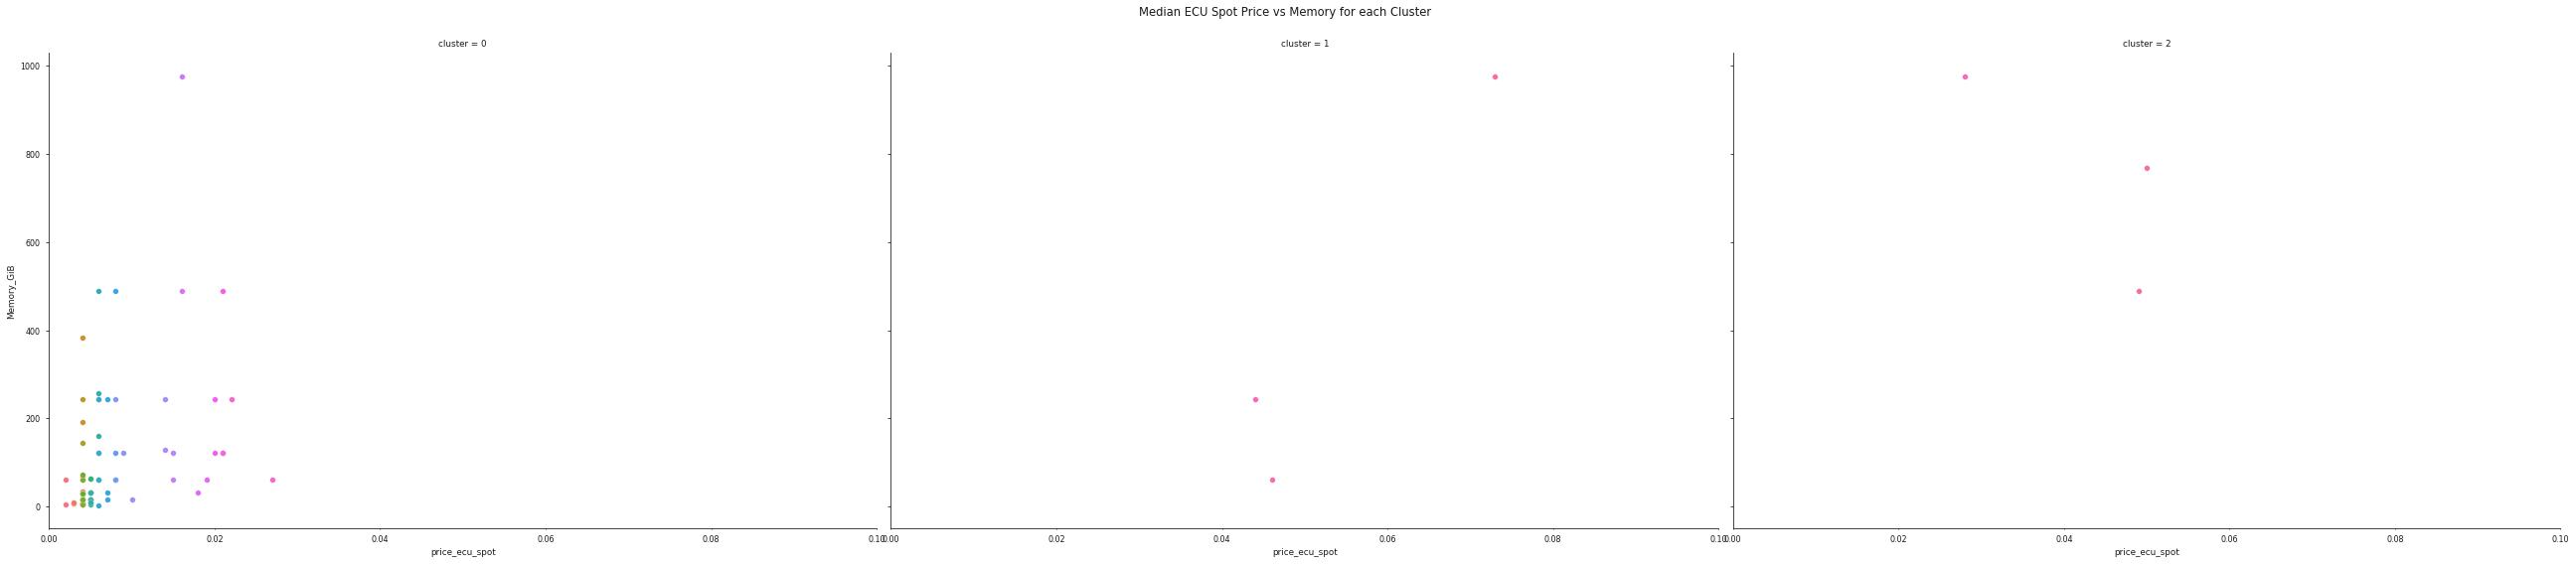

In [24]:
# create some facetgrid plots (make them a little bigger) to see how pricing varies by cluster

g = sns.FacetGrid(df_median, col="cluster",  hue="InstanceType", size=8, aspect=1.5)
g = g.map(plt.scatter, "price_ecu_spot", "Memory_GiB", edgecolor="w")

# set max size of x-axis to round up from max value in data we just downloaded
g.set(xlim=(0,round(max(df_median['price_ecu_spot']),1)))

# add title above all facetgrids; be sure to adjust height of subplots so content does not overlap
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Median ECU Spot Price vs Memory for each Cluster") # can also get the figure from plt.gcf()

Text(0.5,0.98,'Price per unit vs. Price per vCPU')

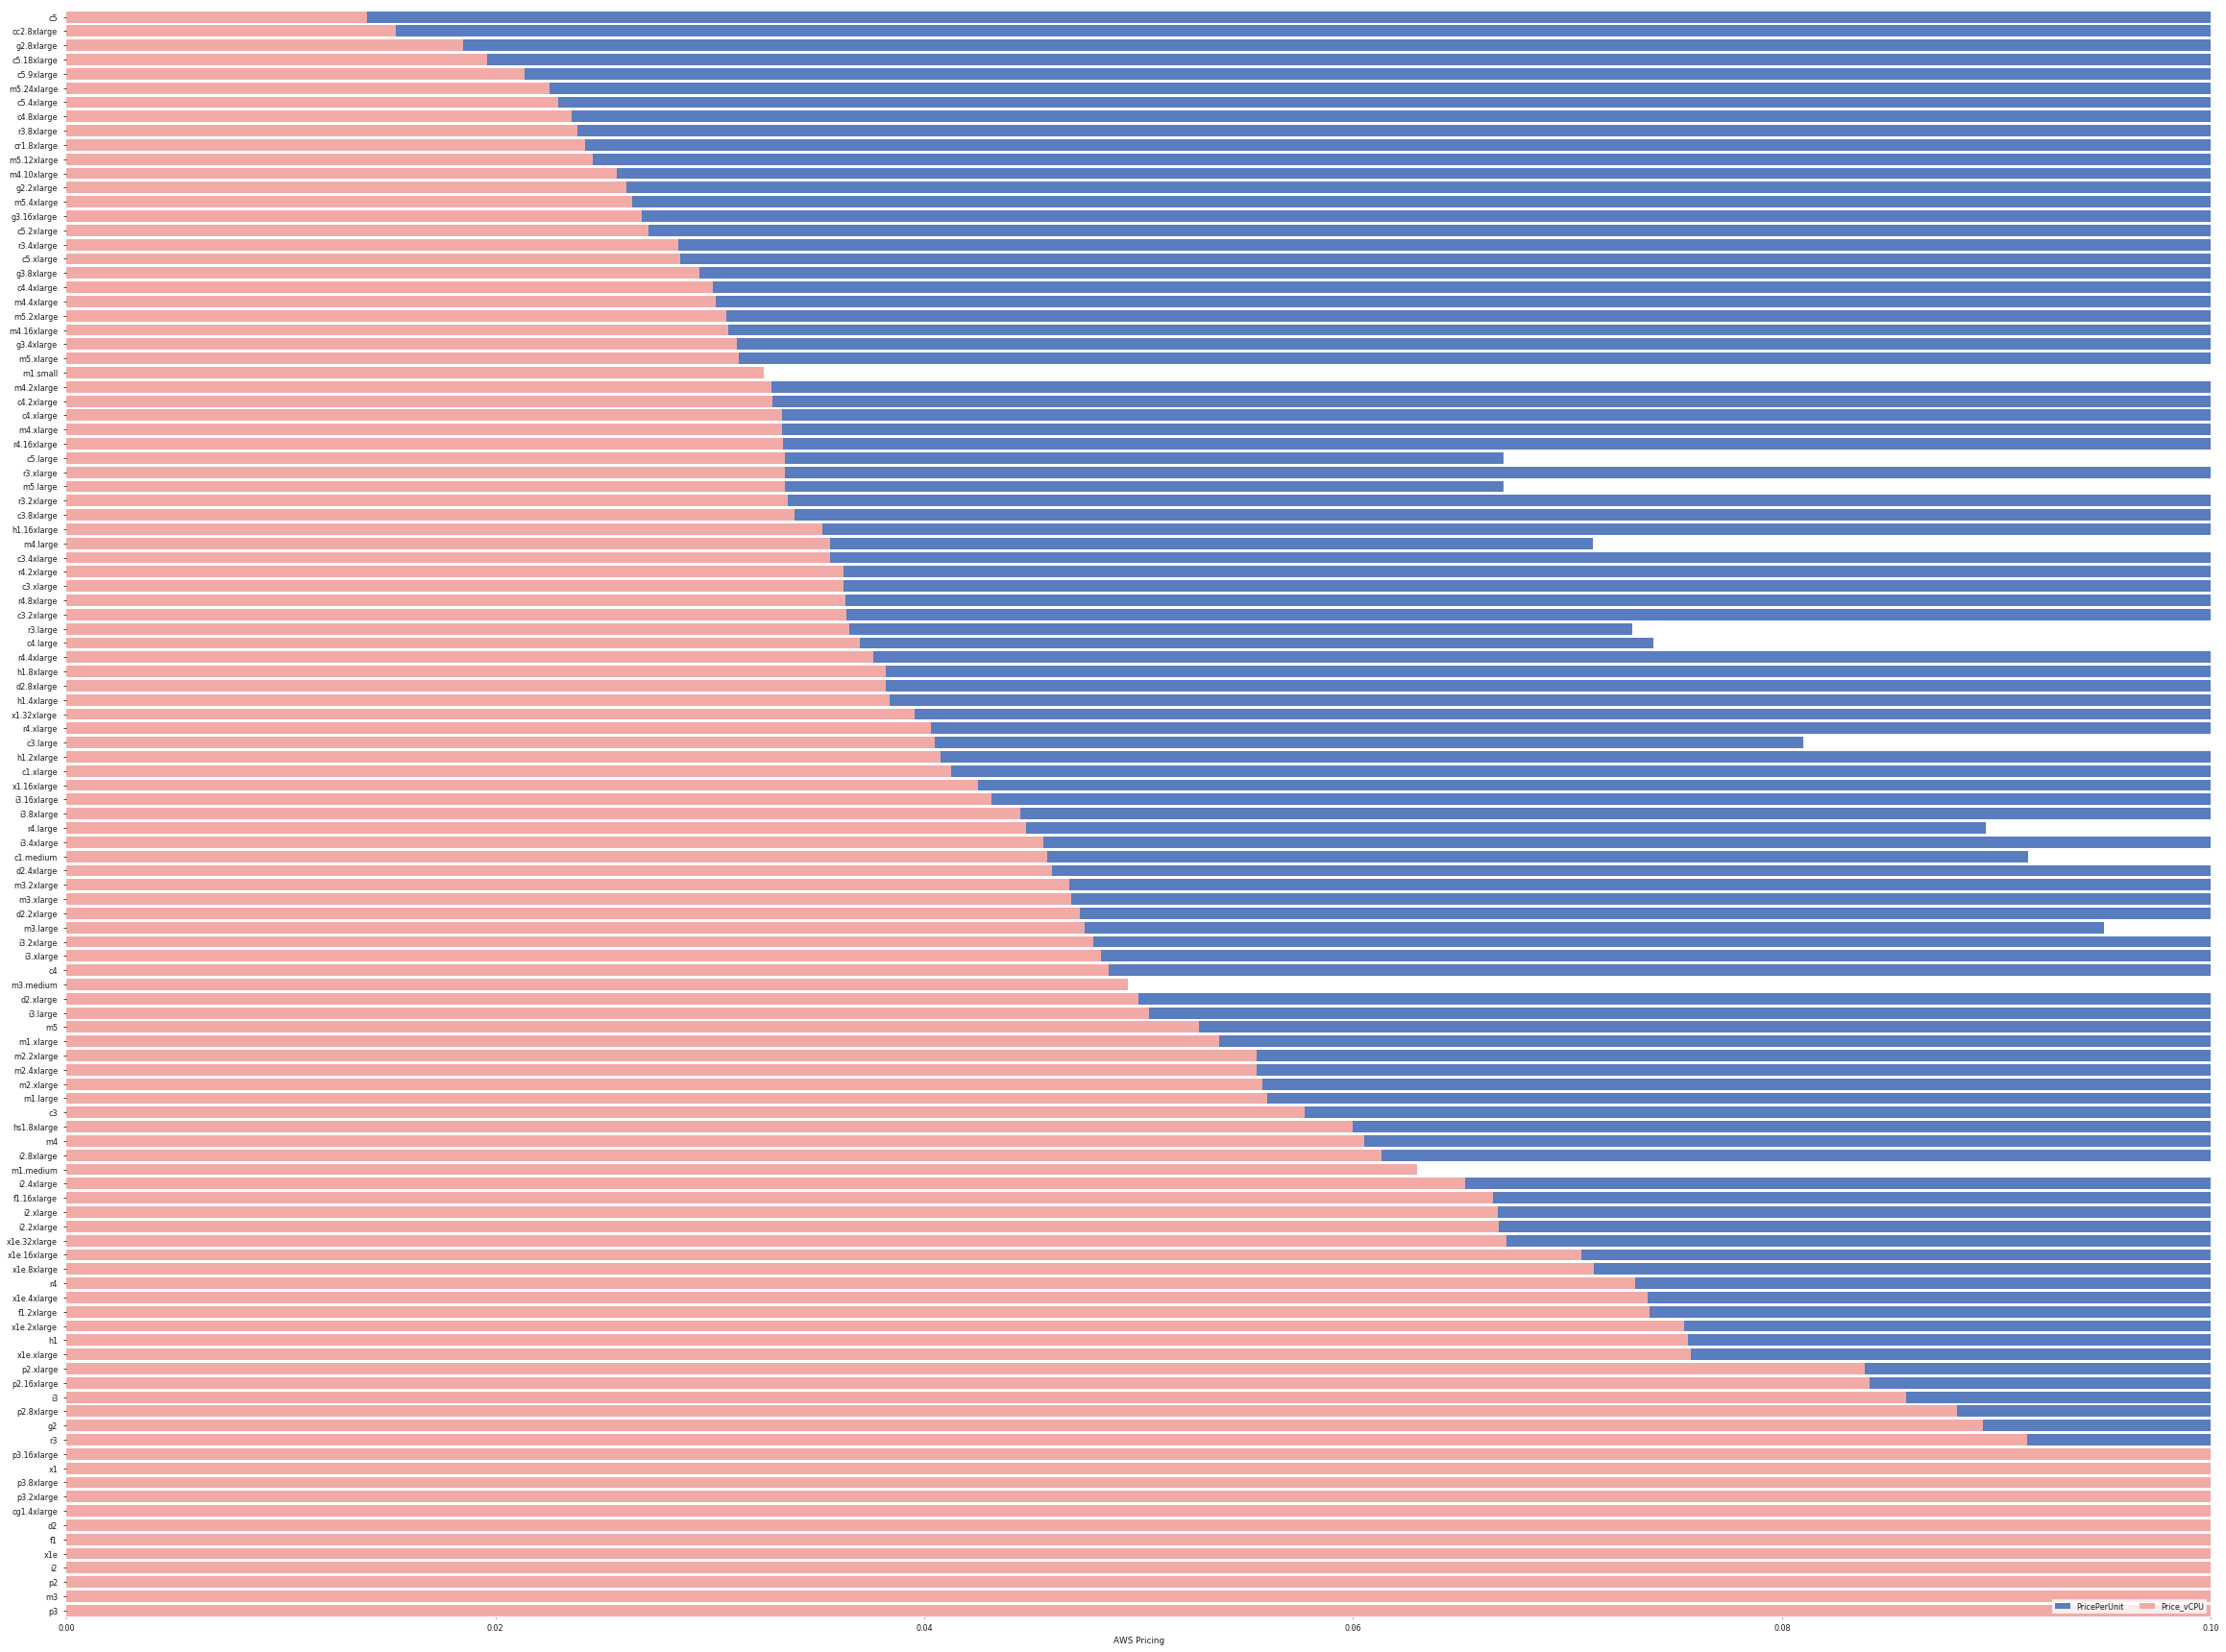

In [25]:
# create new graph - from csv data

pricing_df_median = pricing_df.groupby("Instance Type").median()
pricing_df_median["Instance Type"] = pricing_df_median.index
pricing_df_median["price_ecu"] = pricing_df_median.price_ecu.round(3)
pricing_df_median["divide_ECUPrice"] = pricing_df_median.price_ecu/100
pricing_df_median.sort_values("Price_vCPU", inplace=True)
plt.subplots(figsize=(40,30))
ax = plt.axes()
sns.set_color_codes("muted")
sns.barplot(x="PricePerUnit", y="Instance Type", data=pricing_df_median,
            label="PricePerUnit", color="b")
sns.set_color_codes("pastel")
sns.barplot(x="Price_vCPU", y="Instance Type", data=pricing_df_median,
            label="Price_vCPU", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, .1), ylabel="",
       xlabel="AWS Pricing")
sns.despine(left=True, bottom=True)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Price per unit vs. Price per vCPU") 

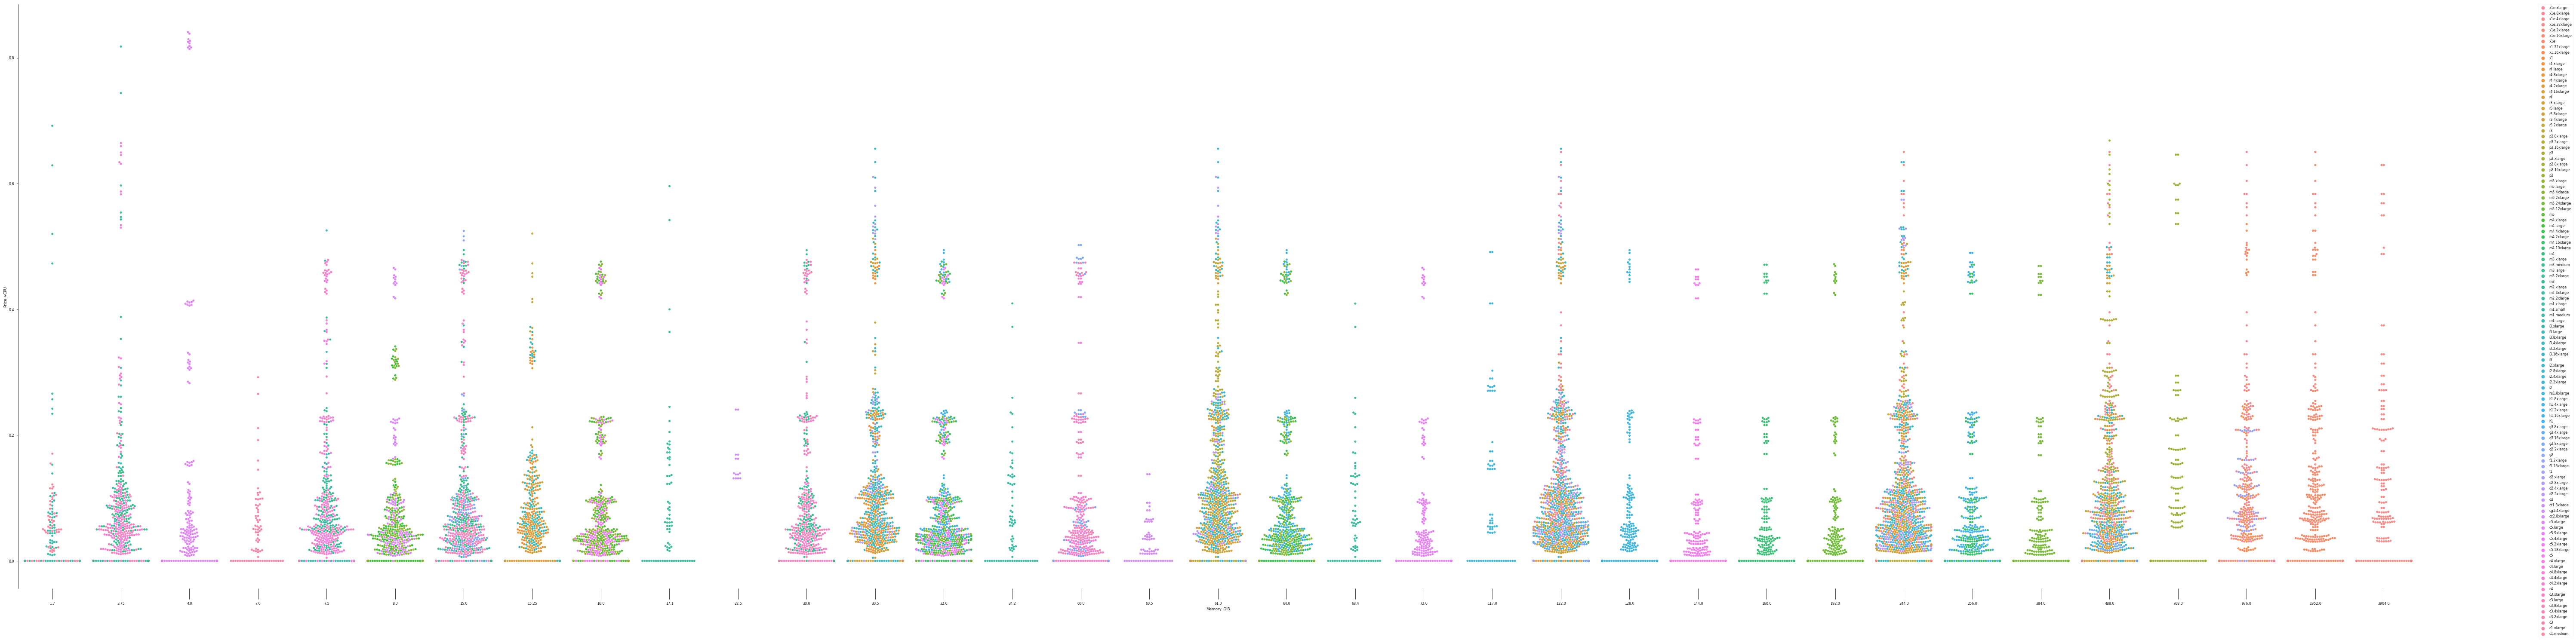

In [26]:
# create swarmplot - from csv data 
# Memory vs Price_vCPU, shade the dots with the Instance Type
# this may help us see patterns of compute power vs price, and how the instances are distributed in relation to each other

sns.set_context('paper')
plt.figure(figsize=(100, 25))
sns.set_style({'xtick.major.size': 25})

sns.swarmplot(x="Memory_GiB", y="Price_vCPU", hue="Instance Type", data=pricing_df)
ax.set(xlim=(0, 5), 
       xlabel="AWS Spot Pricing by Instance Type",
       ylabel="Price per Hour per virtual CPU",)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=False, bottom=True)

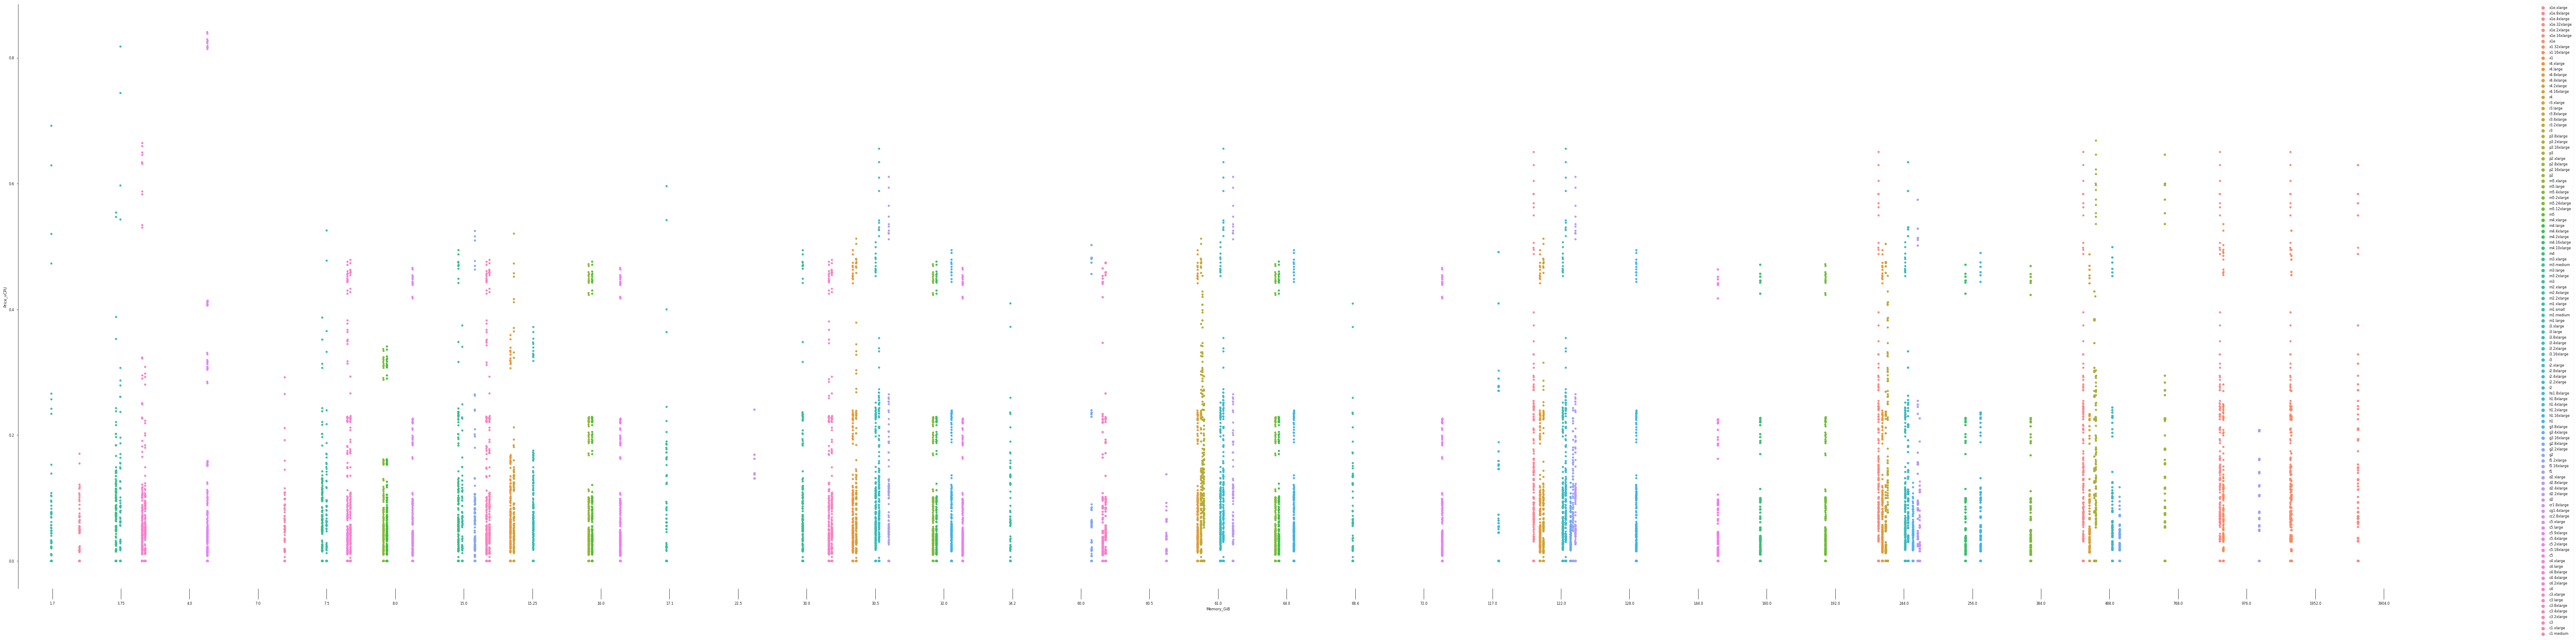

In [27]:
# similar swarmplot - with dodge parameter enabled to offset the plot of each Instance Type
# this is more useful, as we can see that some Instances have three distince price groups of Price/CPU at various memory sizes
# while others have more continuous distribution of pricing.  
# we also note that many instance types share similar price/CPU and memory footprints - supporting the general theme that many different machines can be used for your compute tasks

sns.set_context('paper')
plt.figure(figsize=(100, 25))
sns.set_style({'xtick.major.size': 25})

sns.swarmplot(x="Memory_GiB", y="Price_vCPU", hue="Instance Type", dodge=True, data=pricing_df)
ax.set(xlim=(0, 5), 
       xlabel="AWS Spot Pricing by Instance Type",
       ylabel="Price per Hour per virtual CPU",)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=False, bottom=True)

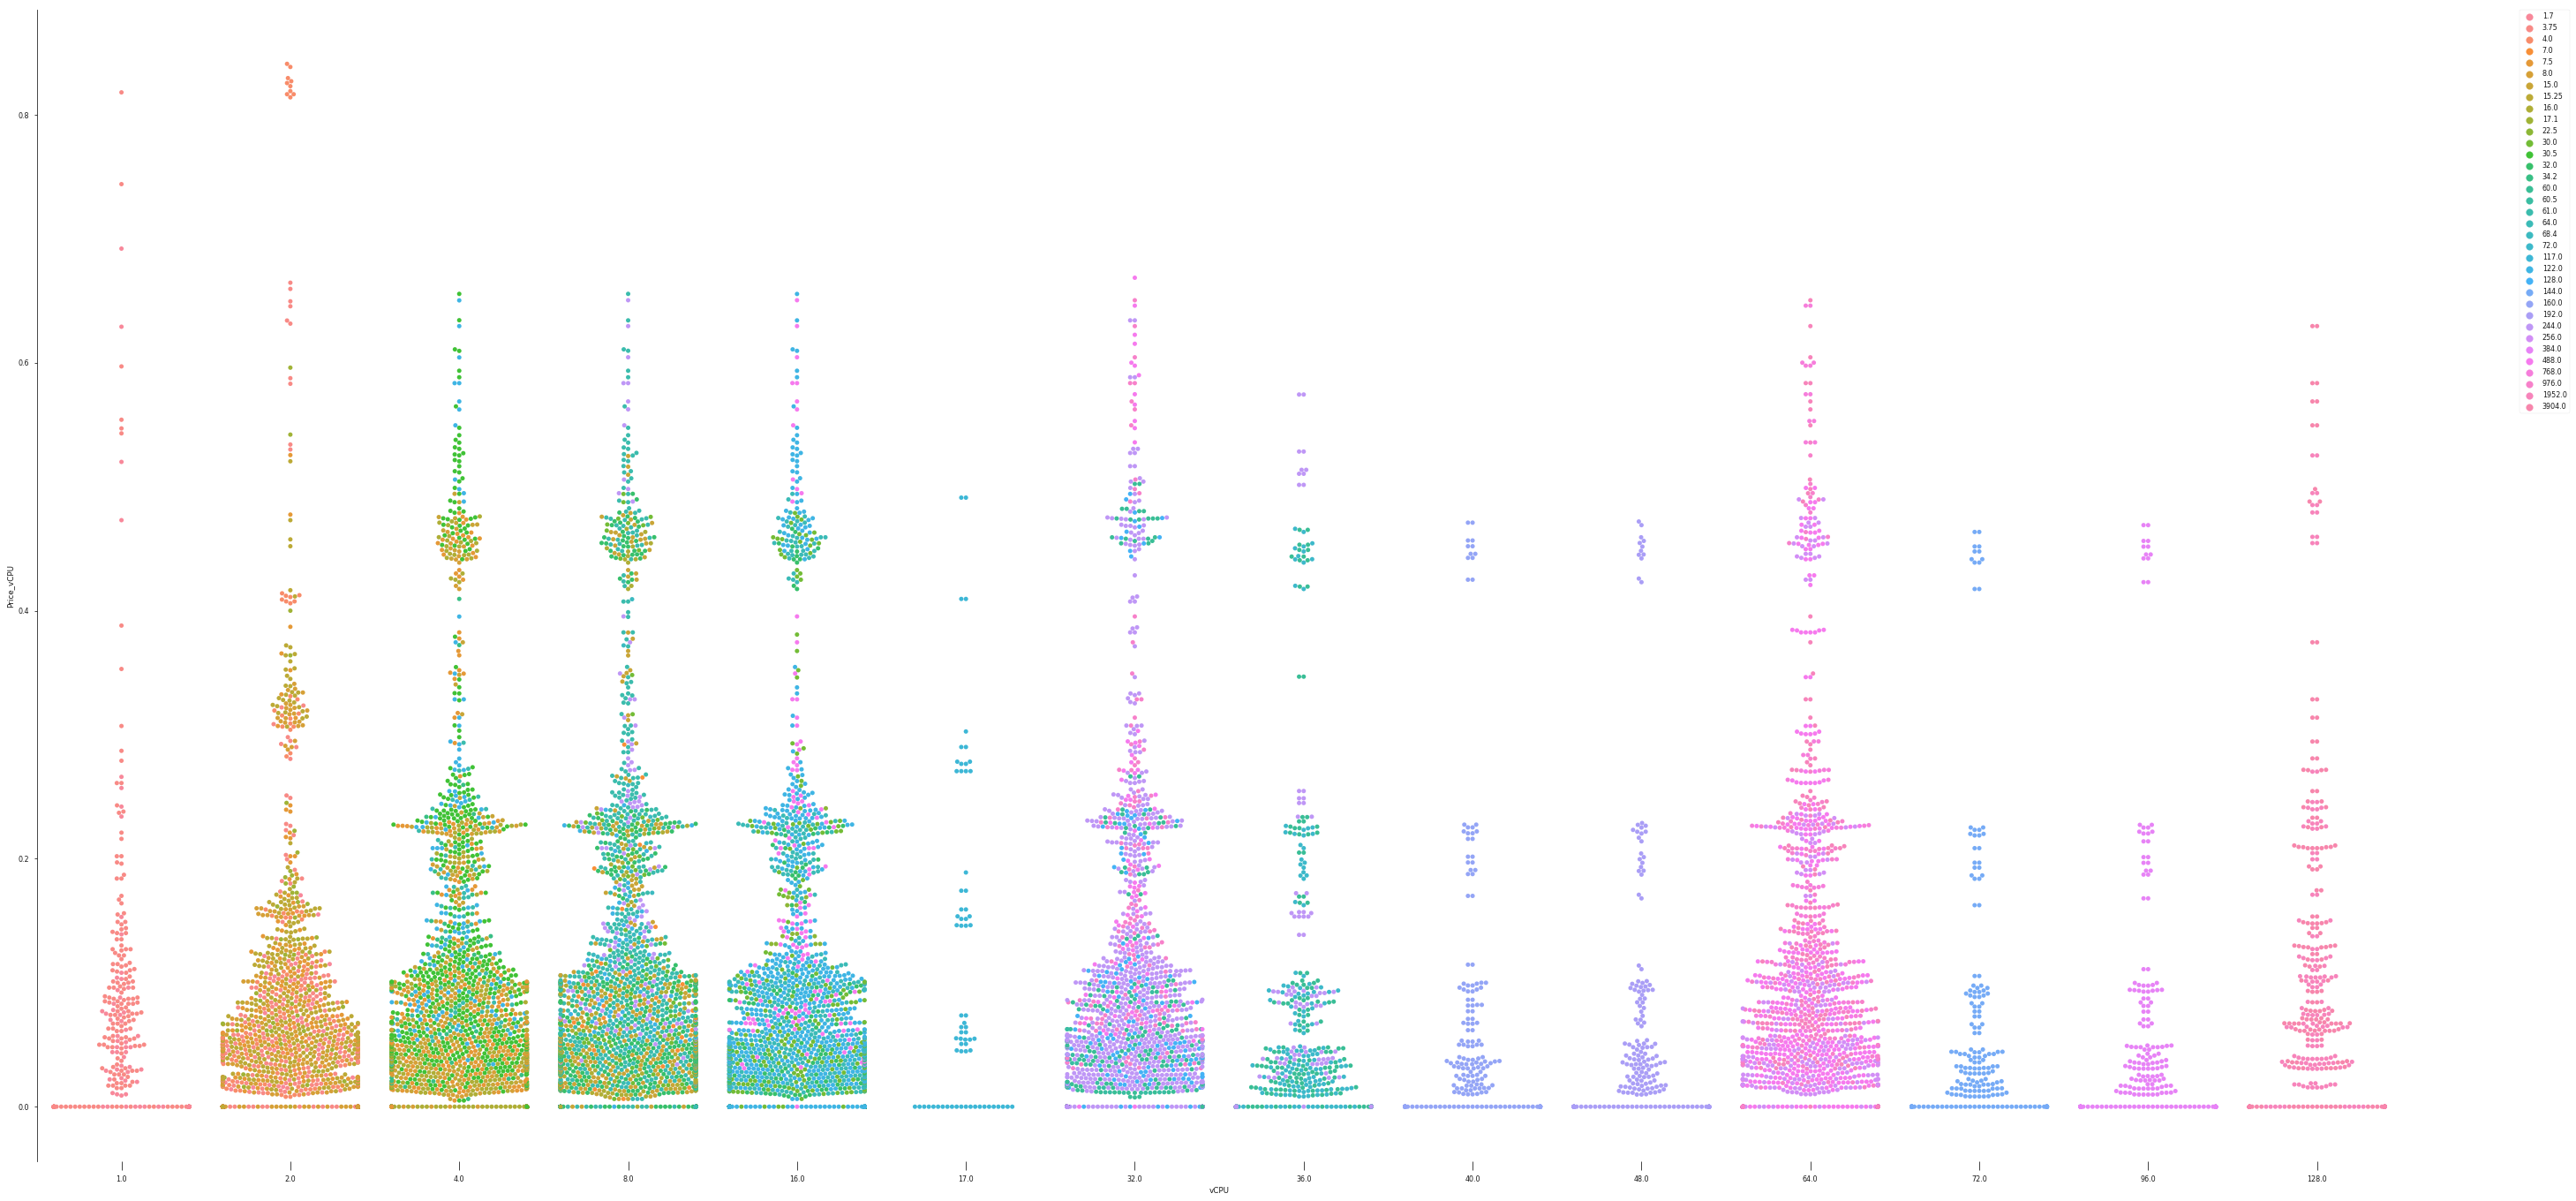

In [28]:
# swarmplot - showing Instance Type family groups as vCPU size grows

sns.set_context('paper')
plt.figure(figsize=(48, 24))
sns.set_style({'xtick.major.size': 10})

sns.swarmplot(x="vCPU", y="Price_vCPU", hue="Memory_GiB", data=pricing_df)
# ax.legend(ncol=2, loc="lower right", frameon=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlim=(0, 5), ylabel="Price per Hour per virtual CPU",
       xlabel="AWS Spot Pricing by Instance Type")
sns.despine(left=False, bottom=True)

# This cell is very slow - 2-3 hours in many cases
##  this cell has been manually changed to 'markdown', you can execute by changing it to 'code' in the jupyter notebook toolbar
##  swarmplot - memory on vertical axis

sns.set_context('paper')
plt.figure(figsize=(48, 24))
sns.set_style({'xtick.major.size': 500})

sns.swarmplot(x="PricePerUnit", y="Memory_GiB", hue="Instance Type", data=pricing_df)
ax.set(xlim=(0, 5), 
       xlabel="AWS Spot Pricing by Instance Type",
       ylabel="Price per Hour per virtual CPU",)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=False, bottom=True)